In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.DBLP import DBLP
import dgl.function as fn
import torch
import numpy as np
import torch_geometric
torch.cuda.empty_cache()


/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:

dataset = DBLP() 
original_graph = dataset.load_graph(n_components=30)
device= "cuda:1"
original_graph = original_graph.to(device)


In [3]:

num_nearest_init_neighbors_per_type = {"papertoauthor": 50, "authortopaper": 50, "conferencetopaper":50, "papertoconference":50,"papertoterm":50, "termtopaper":50, "author":50 , "paper":50, "conference": 50, "term":50}
from Projections.CCA import CCA
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type, use_zscore=False,device=device,
                                cca_cls=CCA, checkpoints=[0.9,0.8,0.7,0.6 ,0.5,0.4, 0.3,0.2,0.1], folder_name="dblp_cca_pca_30_metrics_correct", batch_size=None,
                                pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=True, use_out_degree=False) 

coarsener.init()

coarsener.summarize()

/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


authortopaper
conferencetopaper
papertoauthor
papertoconference
papertoterm
termtopaper
step: 0, ratio: 1.0


/storage/scratch/0994359/hetero-conv-matching/Coarsener/HeteroCoarsener.py:427: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:38.)
  indices = torch.searchsorted(sorted_mapping[:, 0], query_nodes)


step: 1, ratio: 0.9995407225964482
step: 2, ratio: 0.9990814451928965
step: 3, ratio: 0.9986221677893448
step: 4, ratio: 0.9982011635027557
step: 5, ratio: 0.9977801592161666
step: 6, ratio: 0.9973591549295775
step: 7, ratio: 0.9969381506429884
step: 8, ratio: 0.9965171463563993
step: 9, ratio: 0.9960961420698101
step: 10, ratio: 0.995675137783221
step: 11, ratio: 0.9952541334966319
step: 12, ratio: 0.9948331292100429
step: 13, ratio: 0.9944121249234538
step: 14, ratio: 0.9939911206368647
step: 15, ratio: 0.9935701163502756
step: 16, ratio: 0.9931491120636865
step: 17, ratio: 0.9927281077770974
step: 18, ratio: 0.9923071034905082
step: 19, ratio: 0.9918860992039191
step: 20, ratio: 0.99146509491733
step: 21, ratio: 0.991044090630741
step: 22, ratio: 0.9906230863441519
step: 23, ratio: 0.9902020820575628
step: 24, ratio: 0.9897810777709737
step: 25, ratio: 0.9893600734843846
step: 26, ratio: 0.9889390691977955
step: 27, ratio: 0.9885180649112064
step: 28, ratio: 0.9880970606246172
step:

In [3]:
def make_mask(self, mapping, ntype):
    labels_dict = dict()
    inverse_mapping = dict()
    for ori_node, coar_node in mapping.items():
        if coar_node in inverse_mapping:
            inverse_mapping[coar_node].append(ori_node)
        else:
            inverse_mapping[coar_node] = [ori_node]
            
    for coar_node, ori_list in inverse_mapping.items():
        label_list = []
        for ori_node in ori_list:
            label_list.append(self.original_graph.nodes[ntype].data["train_mask"][ori_node].item())
        is_train = torch.any(torch.tensor(label_list, device=self.device))    
        
        is_val = False
        for ori_node in ori_list:
            
            is_val = (self.original_graph.nodes[ntype].data["val_mask"][ori_node] or is_val ) and not is_train
         
    # print(coar_node)
        self.summarized_graph.nodes[ntype].data["train_mask"][coar_node] = is_train
        is_test =  (not is_val and not is_train)
        # print(is_val, is_train, is_test)
        self.summarized_graph.nodes[ntype].data["test_mask"][coar_node] =is_test
        
        
        self.summarized_graph.nodes[ntype].data["val_mask"][coar_node] = is_val

In [4]:
from collections import Counter
def get_labels(self, mapping, ntype):
    # self.make_mask(mapping, ntype)
    labels_dict = dict()
    inverse_mapping = dict()
    for ori_node, coar_node in mapping.items():
        if coar_node in inverse_mapping:
            inverse_mapping[coar_node].append(ori_node)
        else:
            inverse_mapping[coar_node] = [ori_node]
    for coar_node, ori_list in inverse_mapping.items():
        label_list = []
        # if not self.summarized_graph.nodes[ntype].data["train_mask"][coar_node]:
        #     label_list.append(-1)
        # else:
        for ori_node in ori_list:
            if self.original_graph.nodes[ntype].data["train_mask"][ori_node] or not self.summarized_graph.nodes[ntype].data["train_mask"][coar_node]:
                label_list.append(self.original_graph.nodes[ntype].data["label"][ori_node].item())

        counter = Counter(label_list)
        
        labels_dict[coar_node],_ = counter.most_common()[0]
    
    return labels_dict

In [6]:
import pickle
with open(f'results/DBLP_CLL_pca_30_5_pairs_0/0.3', 'rb') as fh:
        
    coarsener = pickle.load(fh) 
coarsend_graph = coarsener.summarized_graph

#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("author")
make_mask(coarsener, mapping, "author")

labels = get_labels(coarsener, mapping, "author")
# coarsend_graph.nodes["author"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=coarsend_graph.device) #,
# print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


In [7]:
coarsend_graph.nodes['author'].data['train_mask'].sum()

tensor(212, device='cuda:0')

In [8]:
coarsend_graph.nodes['author'].data['test_mask'].sum()

tensor(871, device='cuda:0')

In [9]:
any_both_true = (coarsend_graph.nodes['author'].data['train_mask'] & coarsend_graph.nodes['author'].data['val_mask']).sum()
any_both_true

tensor(0, device='cuda:0')

In [10]:
coarsend_graph = coarsend_graph.to('cuda:1')

In [11]:
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes())

ratio 0.29998469075321493


In [14]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import HeteroData

def run_experiments(original_graph, coarsend_graph, model_class, num_runs=5,
                    epochs=100, optimizer=torch.optim.Adam, target_node_type="movie",
                    model_param={"hidden_dim": 256},
                    optimizer_param={"lr": 0.01, "weight_decay": 5e-4},
                    device="cuda" if torch.cuda.is_available() else "cpu",
                    eval_interval=10, run_orig=True,
                    early_stopping_patience=100):

    original_accuracies = []
    coarsened_accuracies = []
    original_loss = []
    coarsened_loss = []

    for run in range(num_runs):
        train_idx_orig = torch.nonzero(original_graph.nodes[target_node_type].data["train_mask"]).squeeze()
        test_idx_orig = torch.nonzero(original_graph.nodes[target_node_type].data["test_mask"]).squeeze()
        val_idx_orig = torch.nonzero(original_graph.nodes[target_node_type].data["val_mask"]).squeeze()
        labels_orig = original_graph.nodes[target_node_type].data['label']

        train_idx_coar = torch.nonzero(coarsend_graph.nodes[target_node_type].data["train_mask"]).squeeze()
        test_idx_coar = torch.nonzero(coarsend_graph.nodes[target_node_type].data["test_mask"]).squeeze()
        val_idx_coar = torch.nonzero(coarsend_graph.nodes[target_node_type].data["val_mask"]).squeeze()
        labels_coar = coarsend_graph.nodes[target_node_type].data['label']

        metadata_orig = (original_graph.ntypes, original_graph.etypes)
        metadata_coar = (coarsend_graph.ntypes, coarsend_graph.etypes)

        feat_orig = {ntype: original_graph.nodes[ntype].data['feat'] for ntype in original_graph.ntypes}
        feat_coar = {ntype: coarsend_graph.nodes[ntype].data['feat'] for ntype in coarsend_graph.ntypes}
        
        output_dim = len(torch.unique(labels_orig))
        model_original = model_class(metadata=metadata_orig,
                                     x_dict=feat_orig,
                                     target_feat=target_node_type,
                                     out_dim=output_dim,
                                     **model_param).to(device)
        optimizer_original = optimizer(model_original.parameters(), **optimizer_param)

        model_coarsened = model_class(metadata=metadata_coar,
                                      x_dict=feat_coar,
                                      target_feat=target_node_type,
                                      out_dim=output_dim,
                                      **model_param).to(device)
        optimizer_coarsened = optimizer(model_coarsened.parameters(), **optimizer_param)

        def train(model, graph, feats, labels, train_idx, optimizer):
            model.train()
            optimizer.zero_grad()
            logits = model(graph, feats)[target_node_type]
            loss = F.cross_entropy(logits[train_idx], labels[train_idx])
            loss.backward()
            optimizer.step()
            return loss

        def test(model, graph, feats, labels, val_idx):
            model.eval()
            with torch.no_grad():
                logits = model(graph, feats)[target_node_type]
                preds = logits.argmax(dim=1)
                correct = (preds[val_idx] == labels[val_idx]).sum().item()
                return correct / val_idx.shape[0], preds

        original_acc_per_run = []
        coarsened_acc_per_run = []
        original_loss_per_run = []
        coarsened_loss_per_run = []

        best_val_acc_orig = 0
        best_val_acc_coar = 0
        patience_counter_orig = 0
        patience_counter_coar = 0
        stop_orig = False
        stop_coar = False

        for epoch in range(epochs):
            # Training only if not early-stopped
            if run_orig and not stop_orig:
                loss_orig = train(model_original, original_graph, feat_orig, labels_orig, train_idx_orig, optimizer_original)
            elif run_orig:
                loss_orig = torch.tensor(0.0)  # Dummy loss for shape consistency

            if not stop_coar:
                loss_coar = train(model_coarsened, coarsend_graph, feat_coar, labels_coar, train_idx_coar, optimizer_coarsened)
            else:
                loss_coar = torch.tensor(0.0)  # Dummy loss

            # Evaluate every eval_interval
            if epoch % eval_interval == 0:
                if run_orig:
                    val_acc_orig, _ = test(model_original, original_graph, feat_orig, labels_orig, val_idx_orig)
                    original_acc_per_run.append(val_acc_orig)
                    original_loss_per_run.append(loss_orig.item())

                    if not stop_orig:
                        if val_acc_orig > best_val_acc_orig:
                            best_val_acc_orig = val_acc_orig
                            patience_counter_orig = 0
                        else:
                            patience_counter_orig += 1
                            if patience_counter_orig >= early_stopping_patience:
                                stop_orig = True

                val_acc_coar, _ = test(model_coarsened, original_graph, feat_orig, labels_orig, val_idx_orig)
                coarsened_acc_per_run.append(val_acc_coar)
                coarsened_loss_per_run.append(loss_coar.item())

                if not stop_coar:
                    if val_acc_coar > best_val_acc_coar:
                        best_val_acc_coar = val_acc_coar
                        patience_counter_coar = 0
                    else:
                        patience_counter_coar += 1
                        if patience_counter_coar >= early_stopping_patience:
                            stop_coar = True

        # Final evaluation
        if run_orig:
            final_acc_orig, _ = test(model_original, original_graph, feat_orig, labels_orig, val_idx_orig)
            original_acc_per_run.append(final_acc_orig)
            original_accuracies.append(original_acc_per_run)
            original_loss.append(original_loss_per_run)

        final_acc_coar, _ = test(model_coarsened, original_graph, feat_orig, labels_orig, val_idx_orig)
        coarsened_acc_per_run.append(final_acc_coar)
        coarsened_accuracies.append(coarsened_acc_per_run)
        coarsened_loss.append(coarsened_loss_per_run)

    return original_accuracies, coarsened_accuracies, original_loss, coarsened_loss


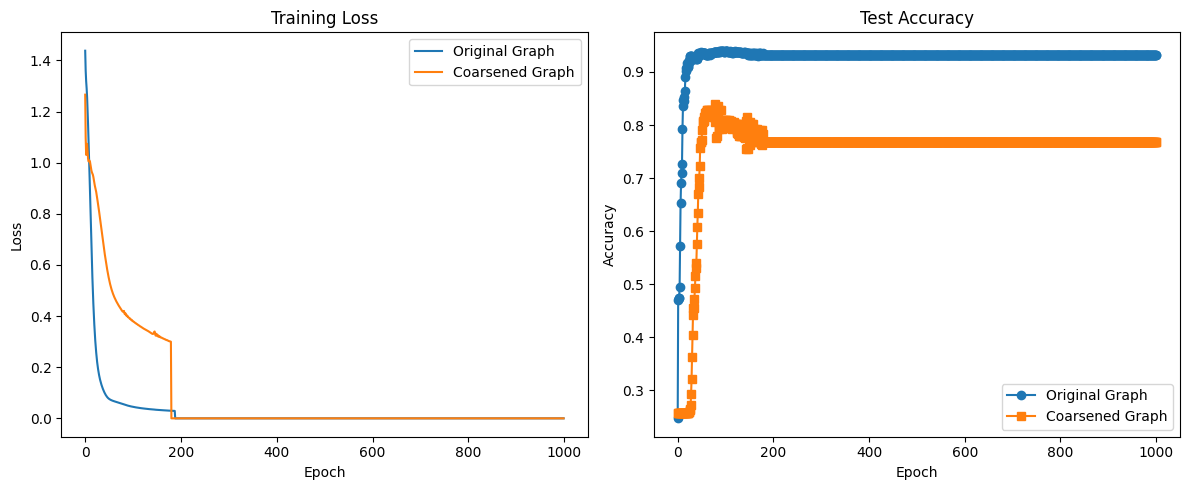

Final Performance Comparison:
Original Graph Accuracy: 0.9325
Coarsened Graph Accuracy: 0.7675

Original Graph Accuracy:
  Mean: 0.9325
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.7675
  Std:  0.0000


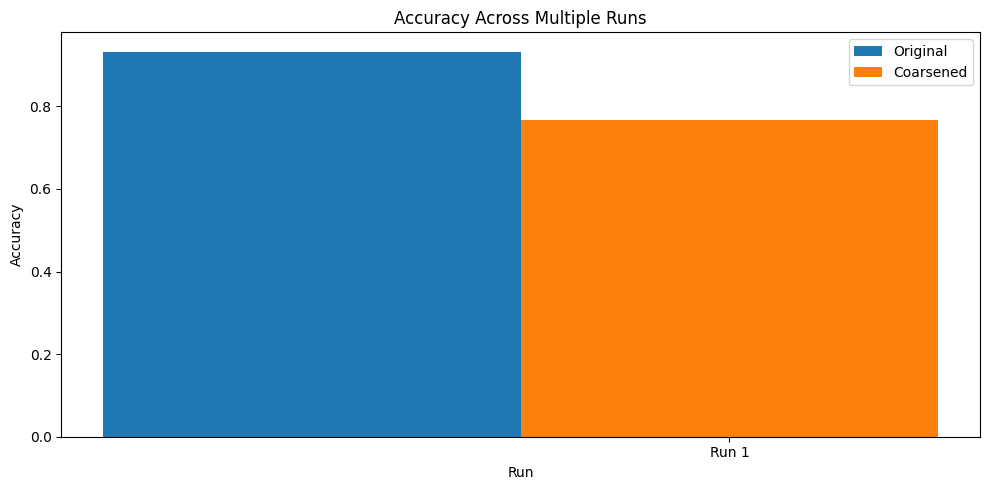

In [16]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSage import HeteroSAGE
from Models.HeteroSGC import HeteroSGCPaper

#from Experiments.model_helper import run_experiments

orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,  HeteroSGCPaper,
                                                  model_param={"hidden_dim": 64,"num_layers":4},
                        optimizer_param={"lr": 0.01, "weight_decay": 5e-4}, device=device,
                        num_runs=1, epochs=1000,eval_interval=1, target_node_type="author")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(len(orig[0] )- 1))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)

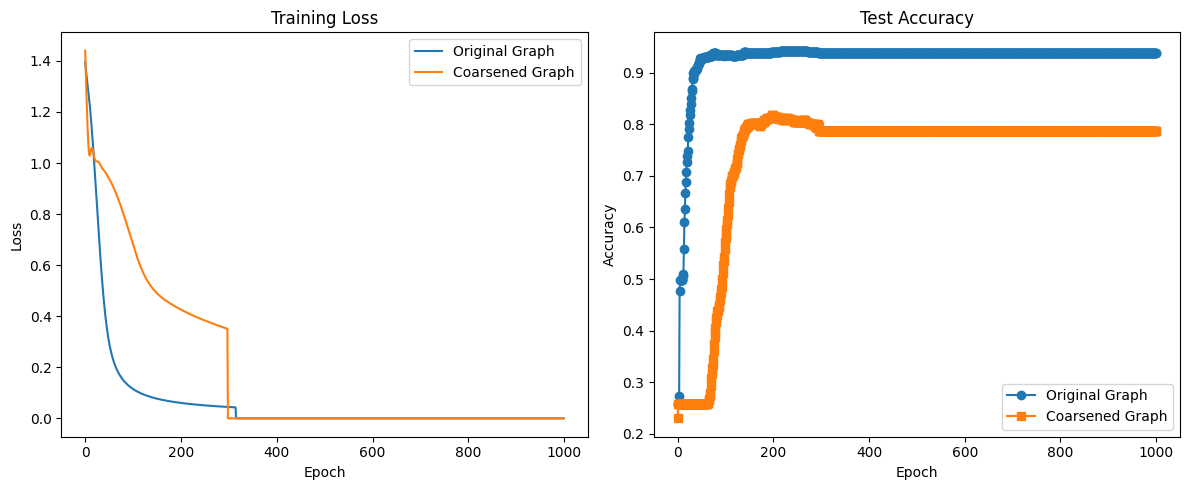

Final Performance Comparison:
Original Graph Accuracy: 0.9375
Coarsened Graph Accuracy: 0.7875

Original Graph Accuracy:
  Mean: 0.9375
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.7875
  Std:  0.0000


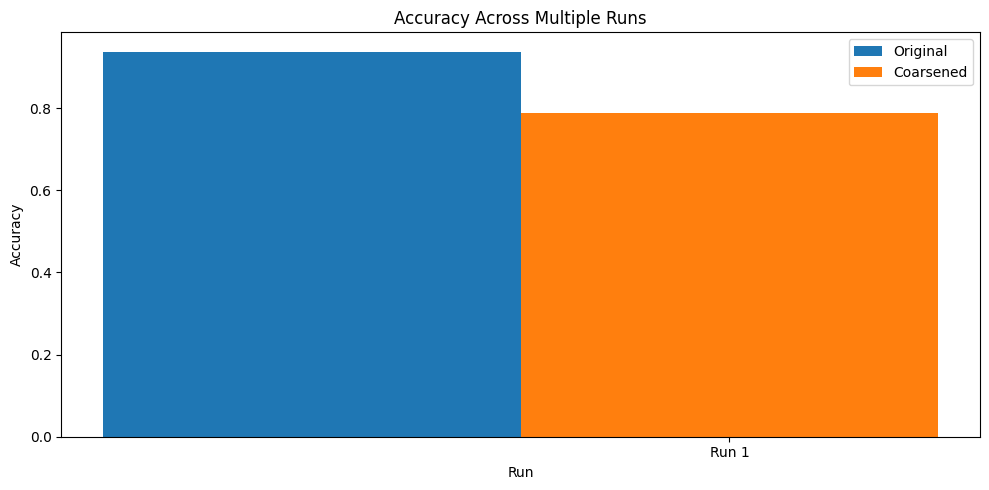

In [17]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSage import HeteroSAGE
from Models.HeteroSGC import HeteroSGCPaper

#from Experiments.model_helper import run_experiments

orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,  HeteroSGCPaper,
                                                  model_param={"hidden_dim": 64,"num_layers":4},
                        optimizer_param={"lr": 0.003, "weight_decay": 5e-4}, device=device,
                        num_runs=1, epochs=1000,eval_interval=1, target_node_type="author")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(len(orig[0] )- 1))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)

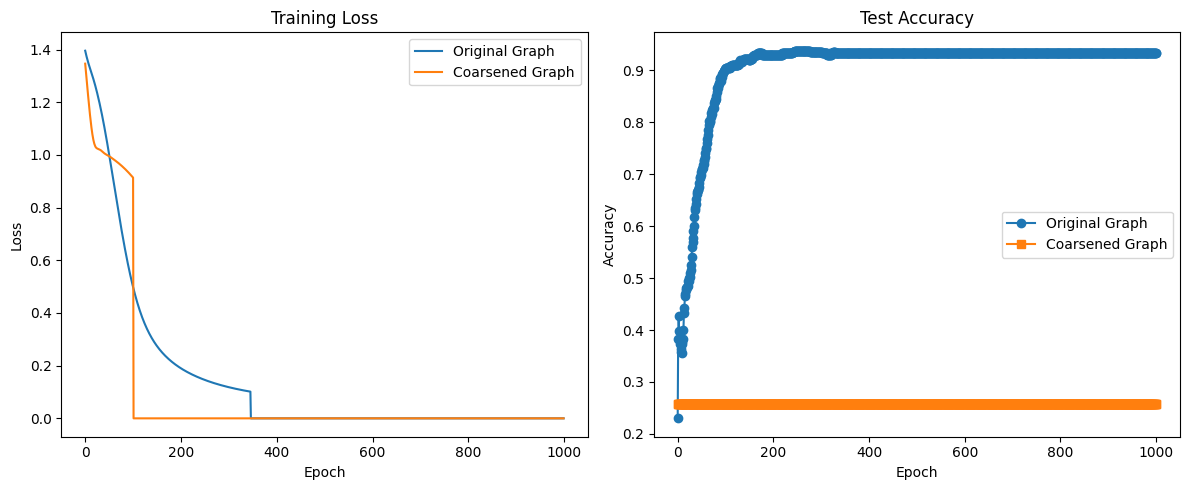

Final Performance Comparison:
Original Graph Accuracy: 0.9325
Coarsened Graph Accuracy: 0.2575

Original Graph Accuracy:
  Mean: 0.9325
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.2575
  Std:  0.0000


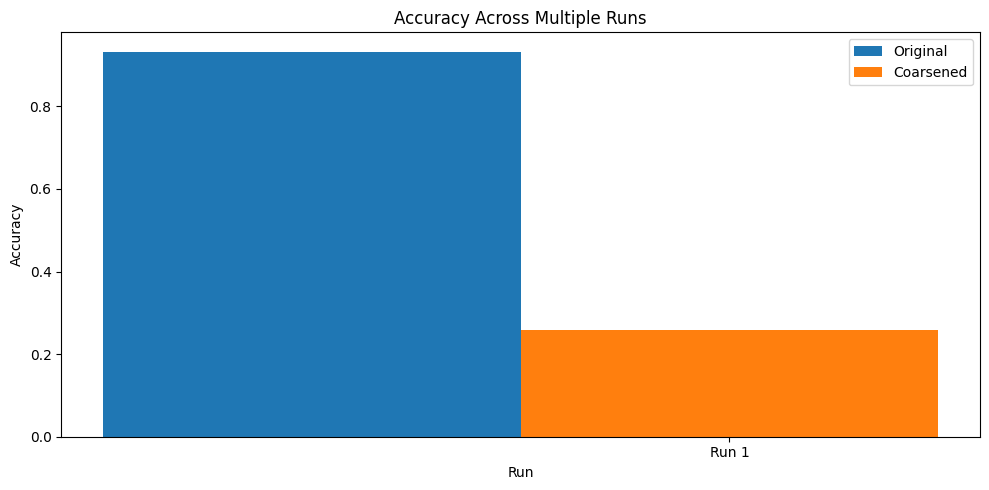

In [18]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSage import HeteroSAGE
from Models.HeteroSGC import HeteroSGCPaper

#from Experiments.model_helper import run_experiments

orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,  HeteroSGCPaper,
                                                  model_param={"hidden_dim": 64,"num_layers":4},
                        optimizer_param={"lr": 0.001, "weight_decay": 5e-4}, device=device,
                        num_runs=1, epochs=1000,eval_interval=1, target_node_type="author")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line

epochs = list(range(len(orig[0] )- 1))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)